In [1]:
import os
import timeit
from datetime import datetime, timedelta
from types import SimpleNamespace

import cdflib
import humanize
import matplotlib.pyplot as plt
import numpy as np
import pycdfpp
import requests
from spacepy import pycdf

SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def download_file(url):
    fname = url.split("/")[-1]
    if not os.path.exists(f"/tmp/cdfpp/{fname}"):
        with open(f"/tmp/cdfpp/{fname}", "wb") as f:
            print(f"downloading {url}")
            f.write(requests.get(url).content)
    return fname


def is_compressed(fname):
    return (
        pycdfpp.load(fname).compression != pycdfpp.CDF_compression_type.no_compression
    )


def file_size(fname):
    return os.stat(fname).st_size


urls = [
    "https://hephaistos.lpp.polytechnique.fr/data/mirrors/CDF/test_files/po_h9_pwi_1997010103_v01.cdf",
    # "https://hephaistos.lpp.polytechnique.fr/data/mirrors/CDF/test_files/bigcdf_compressed.cdf",
    "https://hephaistos.lpp.polytechnique.fr/data/mirrors/CDF/test_files/mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf",
    "https://lasp.colorado.edu/mms/sdc/public/about/browse/mms1/edp/fast/l2/dce/2022/11/mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf",
    "https://lasp.colorado.edu/mms/sdc/public/about/browse/mms1/fpi/fast/l2/des-dist/2022/11/mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221118_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221108_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221027_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221129_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221023_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221003_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20220906_v01.cdf",
]

cdf_corpus = list(map(lambda u: f"/tmp/cdfpp/{u.split('/')[-1]}", urls))

cdf_corpus_details = {
    fname: SimpleNamespace(
        size=file_size(fname),
        size_MB=file_size(fname) / 1000**2,
        is_compressed=is_compressed(fname),
    )
    for fname in cdf_corpus
}

In [3]:
list(map(download_file, urls))

['po_h9_pwi_1997010103_v01.cdf',
 'mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf',
 'mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf',
 'mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf',
 'solo_l3_rpw-bia-efield_20221118_v01.cdf',
 'solo_l3_rpw-bia-efield_20221108_v01.cdf',
 'solo_l3_rpw-bia-efield_20221027_v01.cdf',
 'solo_l3_rpw-bia-efield_20221129_v01.cdf',
 'solo_l3_rpw-bia-efield_20221023_v01.cdf',
 'solo_l3_rpw-bia-efield_20221003_v01.cdf',
 'solo_l3_rpw-bia-efield_20220906_v01.cdf']

In [4]:
class CdfLib:
    @staticmethod
    def just_open(fname):
        c = cdflib.CDF(fname)

    @staticmethod
    def list_variables(fname):
        c = cdflib.CDF(fname)
        cdf_info = c.cdf_info()
        variables = cdf_info.rVariables + cdf_info.zVariables

    @staticmethod
    def get_var_shape(fname, varname):
        shape = cdflib.CDF(fname).varinq(varname).Dim_Sizes

    @staticmethod
    def get_all_var_shapes(fname):
        c = cdflib.CDF(fname)
        cdf_info = c.cdf_info()
        variables = cdf_info.rVariables + cdf_info.zVariables
        [c.varinq(varname).Dim_Sizes for varname in variables]

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = cdflib.CDF(fname)
        for _ in range(ntimes):
            values = c.varget(varname)

    @staticmethod
    def full_load(fname):
        c = cdflib.CDF(fname)
        cdf_info = c.cdf_info()
        variables = cdf_info.rVariables + cdf_info.zVariables
        [c.varget(varname) for varname in variables if c.varinq(varname).Last_Rec != -1]


class SpacePy:
    @staticmethod
    def just_open(fname):
        c = pycdf.CDF(fname)

    @staticmethod
    def list_variables(fname):
        variables = list(pycdf.CDF(fname))

    @staticmethod
    def get_var_shape(fname, varname):
        shape = pycdf.CDF(fname)[varname].shape

    @staticmethod
    def get_all_var_shapes(fname):
        c = pycdf.CDF(fname)
        [c[varname].shape for varname in c]

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = pycdf.CDF(fname)
        for _ in range(ntimes):
            values = c[varname][:]

    @staticmethod
    def full_load(fname):
        c = pycdf.CDF(fname)
        [c.raw_var(varname)[:] for varname in c if len(c.raw_var(varname).shape)]
        # [c[varname][:] for varname in c if len(c.raw_var(varname).shape)]


class PyCdfPp:
    @staticmethod
    def just_open(fname):
        c = pycdfpp.load(fname)

    @staticmethod
    def list_variables(fname):
        variables = list(pycdfpp.load(fname))

    @staticmethod
    def get_var_shape(fname, varname):
        shape = pycdfpp.load(fname)[varname].shape

    @staticmethod
    def get_all_var_shapes(fname):
        c = pycdfpp.load(fname)
        [c[varname].shape for varname in c]

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = pycdfpp.load(fname)
        for _ in range(ntimes):
            values = c[varname].values

    @staticmethod
    def full_load(fname):
        c = pycdfpp.load(fname)
        [c[varname].values for varname in c]


CDF_libs = {"CdfLib": CdfLib, "SpacePy": SpacePy, "PyCdfPp": PyCdfPp}

In [5]:
def bench_method(method, cdf_file, number=1000, **kwargs):
    return dict(
        sorted(
            [
                (
                    lib.__name__,
                    timeit.timeit(
                        lambda: getattr(lib, method)(cdf_file, **kwargs), number=number
                    )
                    / number,
                )
                for lib in (CdfLib, SpacePy, PyCdfPp)
            ],
            key=lambda item: item[1],
        )
    )

# File open speed

Here we only load the file not requesting anything else, implementations doing the less(lazy loading) are expected to be faster.

In [6]:
just_open_results = {
    file: bench_method("just_open", file, number=10) for file in cdf_corpus
}

just_open_results

{'/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf': {'CdfLib': 0.00011845019180327654,
  'SpacePy': 0.001021269499324262,
  'PyCdfPp': 0.005598496901802719},
 '/tmp/cdfpp/mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf': {'CdfLib': 5.003388505429029e-05,
  'PyCdfPp': 0.0023391216062009336,
  'SpacePy': 0.06324282709974796},
 '/tmp/cdfpp/mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf': {'CdfLib': 4.88409074023366e-05,
  'PyCdfPp': 0.005655815009959042,
  'SpacePy': 0.313189458521083},
 '/tmp/cdfpp/mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf': {'CdfLib': 5.1179900765419006e-05,
  'PyCdfPp': 0.0061527339043095704,
  'SpacePy': 0.19972258929628878},
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221118_v01.cdf': {'CdfLib': 4.657790996134281e-05,
  'PyCdfPp': 0.00287203430198133,
  'SpacePy': 0.3076212471816689},
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221108_v01.cdf': {'CdfLib': 4.621290136128664e-05,
  'PyCdfPp': 0.0026543092913925647,
  'SpacePy': 0.0034599430160596966},
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_2

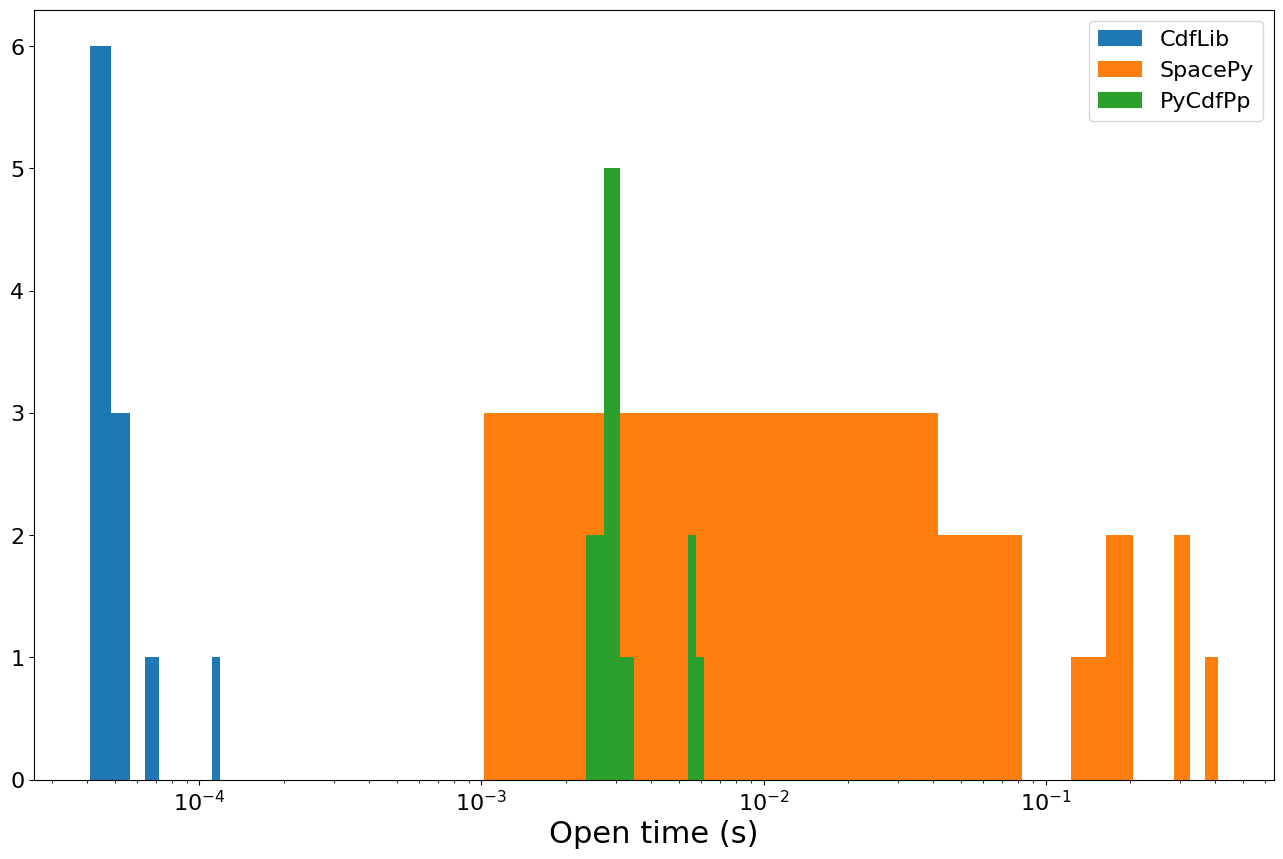

In [7]:
plt.figure(figsize=(16, 10))
for libname in CDF_libs.keys():
    plt.hist([res[libname] for res in just_open_results.values()], label=libname)
plt.semilogx()
plt.xlabel("Open time (s)")
plt.suptitle("")
plt.legend(loc="upper right")
plt.show()

# Variable list

We only list variables names without requesting values

In [8]:
list_variables_results = {
    file: bench_method("list_variables", file, number=10) for file in cdf_corpus
}

list_variables_results

{'/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf': {'CdfLib': 0.00022946821991354227,
  'SpacePy': 0.0006951536983251571,
  'PyCdfPp': 0.0008847301127389073},
 '/tmp/cdfpp/mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf': {'PyCdfPp': 0.00025381059385836123,
  'CdfLib': 0.00028938129544258117,
  'SpacePy': 0.06307638809084892},
 '/tmp/cdfpp/mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf': {'CdfLib': 0.00028879819437861444,
  'PyCdfPp': 0.0006846284959465265,
  'SpacePy': 0.3145281167933717},
 '/tmp/cdfpp/mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf': {'CdfLib': 0.0003594706067815423,
  'PyCdfPp': 0.0007522297091782093,
  'SpacePy': 0.20126984638627618},
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221118_v01.cdf': {'PyCdfPp': 0.0003237068885937333,
  'CdfLib': 0.0004215647000819445,
  'SpacePy': 0.3095048444112763},
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221108_v01.cdf': {'PyCdfPp': 0.00030619860626757145,
  'CdfLib': 0.00041078440845012667,
  'SpacePy': 0.003462389996275306},
 '/tmp/cdfpp/solo_l3_rpw-bi

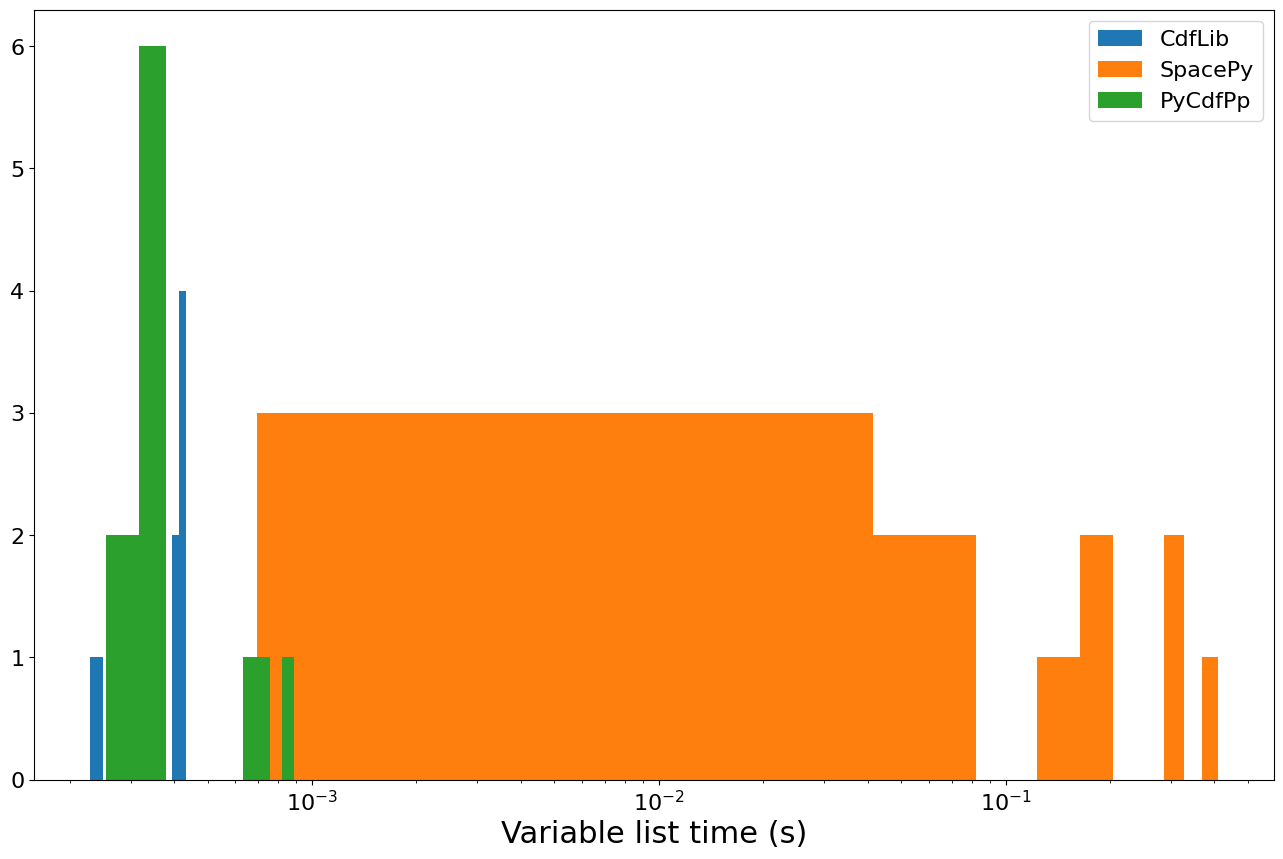

In [9]:
plt.figure(figsize=(16, 10))
for libname in CDF_libs.keys():
    plt.hist([res[libname] for res in list_variables_results.values()], label=libname)
plt.semilogx()
plt.xlabel("Variable list time (s)")
plt.suptitle("")
plt.legend(loc="upper right")
plt.show()

# Variables shapes list

We only list variables shapes without requesting variables values

In [10]:
get_all_var_shapes_results = {
    file: bench_method("get_all_var_shapes", file, number=10) for file in cdf_corpus
}

get_all_var_shapes_results

{'/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf': {'PyCdfPp': 0.0005290796048939228,
  'CdfLib': 0.0006277394015341998,
  'SpacePy': 0.0009338100207969546},
 '/tmp/cdfpp/mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf': {'PyCdfPp': 0.000286058196797967,
  'CdfLib': 0.0004298357991501689,
  'SpacePy': 0.06398020959459245},
 '/tmp/cdfpp/mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf': {'PyCdfPp': 0.0006665471941232681,
  'CdfLib': 0.0010692064184695481,
  'SpacePy': 0.3151076663983986},
 '/tmp/cdfpp/mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf': {'PyCdfPp': 0.0008280969923362136,
  'CdfLib': 0.0010900548892095684,
  'SpacePy': 0.1997017099056393},
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221118_v01.cdf': {'PyCdfPp': 0.0003930801991373301,
  'CdfLib': 0.0006177431903779506,
  'SpacePy': 0.3162377949804068},
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221108_v01.cdf': {'PyCdfPp': 0.00036706868559122086,
  'CdfLib': 0.0005899507086724043,
  'SpacePy': 0.00353370129596442},
 '/tmp/cdfpp/solo_l3_rpw-bia-efield

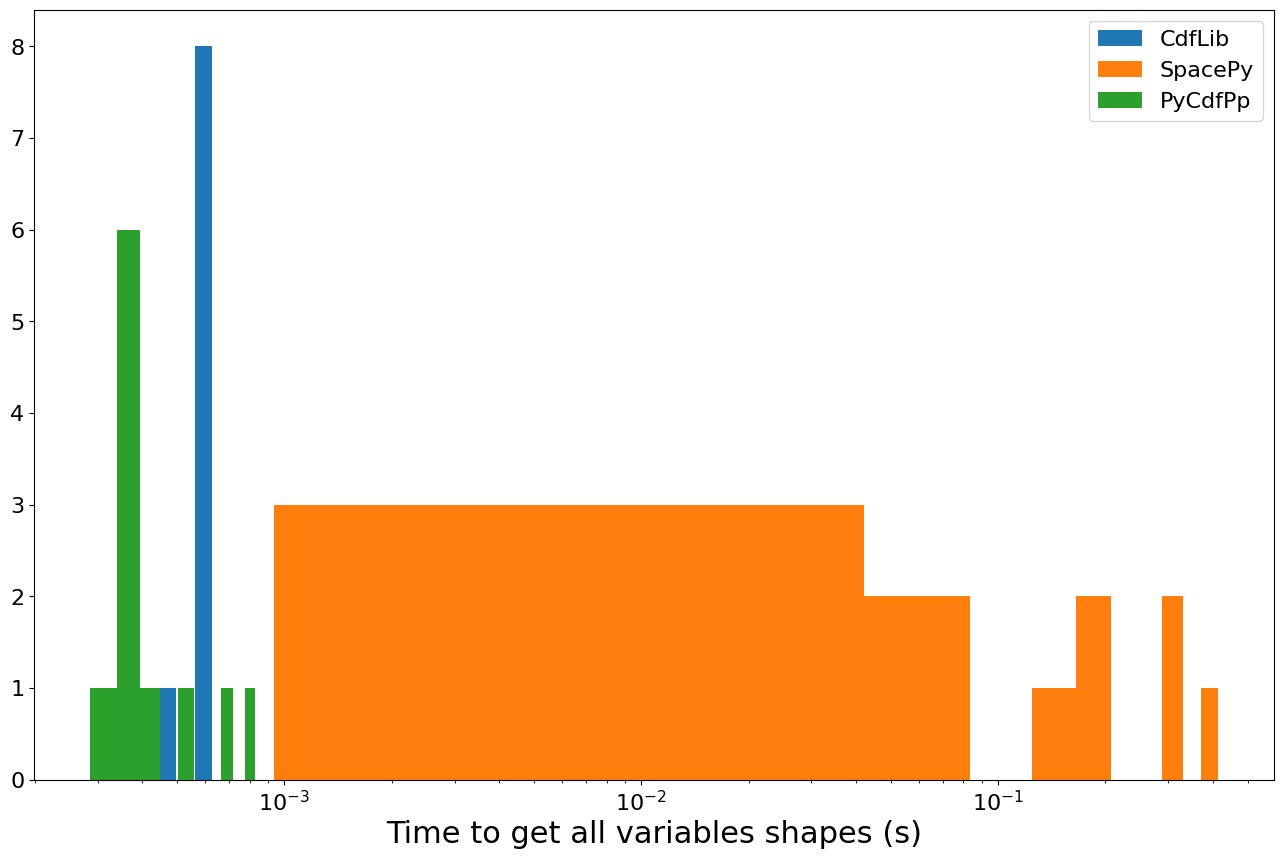

In [11]:
plt.figure(figsize=(16, 10))
for libname in CDF_libs.keys():
    plt.hist(
        [res[libname] for res in get_all_var_shapes_results.values()], label=libname
    )
plt.semilogx()
plt.xlabel("Time to get all variables shapes (s)")
plt.suptitle("")
plt.legend(loc="upper right")
plt.show()

# Full CDF file loading
We request all variables values.

In [12]:
full_load_results = {
    file: bench_method("full_load", file, number=10) for file in cdf_corpus
}

full_load_results

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe0 in position 1: invalid continuation byte

In [ ]:
plt.figure(figsize=(16, 10))
for libname in CDF_libs.keys():
    plt.hist(
        [
            res[libname] / cdf_corpus_details[fname].size_MB
            for fname, res in full_load_results.items()
        ],
        label=libname,
    )
plt.semilogx()
plt.xlabel("Time per mega Byte (s/MB)")
plt.suptitle("Time to load all variables values normalized by file size")
plt.legend(loc="upper right")
plt.show()

In [ ]:
sizes = [cdf_corpus_details[f].size / 1024**2 for f in cdf_corpus]

plt.figure(figsize=(16, 10))
for marker, libname in zip(("*", "^", "o"), CDF_libs):
    plt.scatter(
        sizes,
        [res[libname] for res in full_load_results.values()],
        label=libname,
        marker=marker,
    )
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 200, label="0.2GB/s")
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 1000, label="1GB/s")
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 2000, label="2GB/s")
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 4000, label="4GB/s")
plt.loglog()
plt.xlabel("File size (MB)")
plt.ylabel("Load time (s)")
plt.legend(loc="upper left")
plt.suptitle("CDF implementations read speed")
plt.show()

# Scalability analysis

While previous test shows some linear tendency, not all tests are done with the same dataset which is likely to add noise

In [ ]:
def create_file(
    samples=1000, var_count=4, with_time_var=True, fname="/tmp/cdfpp/scalability.cdf"
):
    if os.path.exists(fname):
        os.unlink(fname)
    cd = pycdf.CDF(fname, "")
    for var in range(var_count):
        var = cd.new(
            f"data_variable_{var}",
            data=np.cos(np.arange(samples // var_count) / 100) * 100 * var,
            type=pycdf.const.CDF_INT4,
        )
        var.attrs = {"attr1": "attr1_value", "attr2": "attr2_value"}
    if with_time_var:
        var = cd.new(
            f"Epoch",
            data=[
                datetime(1970, 1, 1) + timedelta(seconds=i)
                for i in range(int(samples) // var_count)
            ],
            type=pycdf.const.CDF_TIME_TT2000,
        )
    cd.close()
    return fname

In [ ]:
sizes = []
times = []
for size in np.linspace(1e5, 8e7, num=5):
    fname = create_file(samples=size)
    sizes.append(file_size(fname) / 1024**2)
    times.append(bench_method("full_load", fname, number=1))

In [ ]:
plt.figure(figsize=(16, 10))
for marker, libname in zip(("*", "^", "o"), CDF_libs):
    plt.scatter(
        sizes,
        [res[libname] for res in times],
        label=libname,
        marker=marker,
    )
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 500, label="0.5GB/s")
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 2000, label="2GB/s")
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 4000, label="4GB/s")
# plt.loglog()
plt.xlabel("File size (MB)")
plt.ylabel("Load time (s)")
plt.legend(loc="upper left")
plt.suptitle("CDF implementations read speed")
plt.show()